In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path
path = Path.cwd().parents[0]
if str(path) not in sys.path:
    sys.path.append(str(path))

In [114]:
# Imports
trials = 50
n=100
noise = 0.5
kernel = "gaussian"

results_kl = torch.load(path / "causalklgp/ablation_causalklgp_ntrial={0}_n={1}_d=5_noise={2}_kernel={3}.pt".format(trials,n,noise, kernel),
                         weights_only = True)
results_bimp = torch.load(path / "bayesimp/ablation_bayesimp_ntrial={0}_n={1}_d=5_noise={2}_kernel={3}.pt".format(trials,n,noise, kernel),
                         weights_only = True)
results_bgp = torch.load(path / "baselinegp/ablation_baselinegp_ntrial={0}_n={1}_d=5_noise={2}_kernel={3}.pt".format(trials,n,noise, kernel),
                         weights_only = True)

# Getting dimensions and names
levels = results_kl[0]['cal_levels']
n_level = len(levels)
n_result_kl = len(results_kl)
n_model_kl = int(n_result_kl/trials)
n_result_bimp = len(results_bimp)
n_model_bimp = int(n_result_bimp/trials)
n_result_bgp = len(results_bgp)
n_model_bgp = int(n_result_bgp/trials)
names = []

In [115]:
# RMSE table
rmse_kl = torch.zeros(len(results_kl))
rmse_bimp = torch.zeros(len(results_bimp))
rmse_bgp = torch.zeros(len(results_bgp))

for i in range(len(results_kl)):
    rmse_kl[i] = results_kl[i]['rmse']
for i in range(len(results_bimp)):
    rmse_bimp[i] = results_bimp[i]['rmse']
for i in range(len(results_bgp)):
    rmse_bgp[i] = results_bgp[i]['rmse']
    
rmse_kl = rmse_kl.reshape(n_model_kl,trials).T
rmse_bimp = rmse_bimp.reshape(n_model_bimp,trials).T
rmse_bgp = rmse_bgp.reshape(n_model_bgp,trials).T

print(rmse_kl.mean(0), rmse_kl.var(0)**0.5/trials**0.5)
print(rmse_bimp.mean(0), rmse_bimp.var(0)**0.5/trials**0.5)
print(rmse_bgp.mean(0), rmse_bgp.var(0)**0.5/trials**0.5)

tensor([0.2346, 0.2251, 0.2322]) tensor([0.0108, 0.0062, 0.0098])
tensor([0.3723, 0.2823]) tensor([0.0265, 0.0147])
tensor([0.2806]) tensor([0.0086])


tensor([0.1040, 0.0690, 0.0432])
tensor([0.1805, 0.1813])
tensor([0.1222])


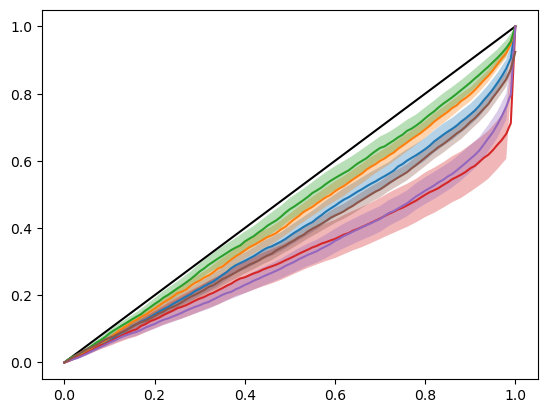

In [116]:
# Getting calibration curves
z = 1.645

post_levels_kl = torch.zeros(len(results_kl),n_level)
post_levels_bimp = torch.zeros(len(results_bimp),n_level)
post_levels_bgp = torch.zeros(len(results_bgp),n_level)

for i in range(len(results_kl)):
    post_levels_kl[i] =  results_kl[i]['post_levels'].mean(0)
for i in range(len(results_bimp)):
    post_levels_bimp[i] =  results_bimp[i]['post_levels'].mean(0)
for i in range(len(results_bgp)):
    post_levels_bgp[i] =  results_bgp[i]['post_levels'].mean(0)
    
post_levels_kl = post_levels_kl.reshape(n_model_kl,trials,n_level)
post_levels_bimp = post_levels_bimp.reshape(n_model_bimp,trials,n_level)
post_levels_bgp = post_levels_bgp.reshape(n_model_bgp,trials,n_level)

plt.plot(levels,levels, color = "black")
plt.plot(levels,post_levels_kl.mean(1).T);
for i in range(n_model_kl):
     plt.fill_between(levels[plot_inds][:,0],
                     post_levels_kl.mean(1).T[plot_inds,...,i] - z*post_levels_kl.var(1).T[plot_inds,...,i]**0.5/trials**0.5,
                     post_levels_kl.mean(1).T[plot_inds,...,i] + z*post_levels_kl.var(1).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.33);
plt.plot(levels,post_levels_bimp.mean(1).T);
for i in range(n_model_bimp):
     plt.fill_between(levels[plot_inds][:,0],
                     post_levels_bimp.mean(1).T[plot_inds,...,i] - z*post_levels_bimp.var(1).T[plot_inds,...,i]**0.5/trials**0.5,
                     post_levels_bimp.mean(1).T[plot_inds,...,i] + z*post_levels_bimp.var(1).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.33);
plt.plot(levels,post_levels_bgp.mean(1).T);
for i in range(n_model_bgp):
     plt.fill_between(levels[plot_inds][:,0],
                     post_levels_bgp.mean(1).T[plot_inds,...,i] - z*post_levels_bgp.var(1).T[plot_inds,...,i]**0.5/trials**0.5,
                     post_levels_bgp.mean(1).T[plot_inds,...,i] + z*post_levels_bgp.var(1).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.33);

print((post_levels_kl.mean(1).T-levels).abs().mean(0))
print((post_levels_bimp.mean(1).T-levels).abs().mean(0))
print((post_levels_bgp.mean(1).T-levels).abs().mean(0))

tensor([0.1103, 0.0832, 0.0691])
tensor([0.1849, 0.1829])
tensor([0.1313])


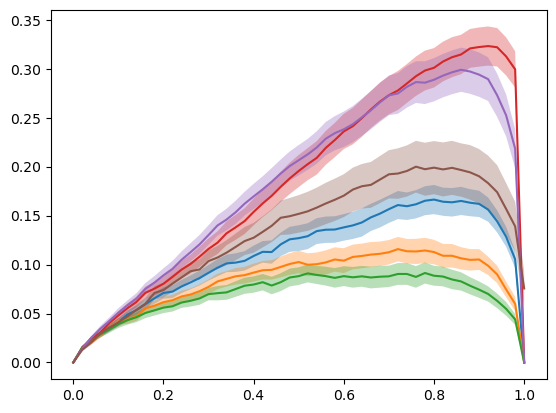

In [117]:
# Getting calibration losses
z = 1.0

post_levels_kl = torch.zeros(100,n_model_kl,n_level)
post_levels_bimp = torch.zeros(100,n_model_bimp,n_level)
post_levels_bgp = torch.zeros(100,n_model_bgp,n_level)

for t in range(trials):
    for m in range(n_model_kl):
        post_levels_kl[:,m] +=  results_kl[trials*m+t]['post_levels']/trials
    for m in range(n_model_bimp):
        post_levels_bimp[:,m] +=  results_bimp[trials*m+t]['post_levels']/trials
    for m in range(n_model_bgp):
        post_levels_bgp[:,m] +=  results_bgp[trials*m+t]['post_levels']/trials
        
cal_loss_kl = (post_levels_kl - levels.T[None]).abs()
cal_loss_bimp = (post_levels_bimp - levels.T[None]).abs()
cal_loss_bgp = (post_levels_bgp - levels.T[None]).abs()

print(cal_loss_kl.mean((0,2)))
print(cal_loss_bimp.mean((0,2)))
print(cal_loss_bgp.mean((0,2)))

plot_inds = 2*torch.arange(51)

plt.plot(levels[plot_inds],cal_loss_kl.mean(0).T[plot_inds]);
plt.plot(levels[plot_inds],cal_loss_bimp.mean(0).T[plot_inds]);
plt.plot(levels[plot_inds],cal_loss_bgp.mean(0).T[plot_inds]);
for i in range(n_model_kl):
    plt.fill_between(levels[plot_inds][:,0],
                     cal_loss_kl.mean(0).T[plot_inds,...,i] - z*cal_loss_kl.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     cal_loss_kl.mean(0).T[plot_inds,...,i] + z*cal_loss_kl.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.33);
for i in range(n_model_bimp):
    plt.fill_between(levels[plot_inds][:,0],
                     cal_loss_bimp.mean(0).T[plot_inds,...,i] - z*cal_loss_bimp.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     cal_loss_bimp.mean(0).T[plot_inds,...,i] + z*cal_loss_bimp.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.33);
for i in range(n_model_bgp):
    plt.fill_between(levels[plot_inds][:,0],
                     cal_loss_bgp.mean(0).T[plot_inds,...,i] - z*cal_loss_bgp.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     cal_loss_bgp.mean(0).T[plot_inds,...,i] + z*cal_loss_bgp.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.33);